In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from torch import nn # nn contains all of PyTorch's building blocks of neural networks
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns

/home/user/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def categorize(dataframe):
    a_values = dataframe['unitcell_a'].values
    b_values = dataframe['unitcell_b'].values
    alpha_values = dataframe['unitcell_alpha'].values
    beta_values = dataframe['unitcell_beta'].values
    gamma_values = dataframe['unitcell_gamma'].values
    categories = []
    for i in range(len(a_values)):
        a_equals_b = round(a_values[i], 2) == round(b_values[i], 2)
        gamma_equals_90 = 80 <= gamma_values[i] <= 100
        gamma_equals_60 = 50 <= gamma_values[i] <= 70
        gamma_equals_120 = 110 <= gamma_values[i] <= 130
        
        if a_equals_b:
            if gamma_equals_90:
                categories.append('Square')
            elif gamma_equals_60 or gamma_equals_120:
                categories.append('Hexagonal')
            else:
                categories.append('Uncategorized')
                
        else:
            if gamma_equals_90:
                categories.append('Rectangular')
            else:
                categories.append('Uncategorized')
                
    return categories

In [3]:
df = pd.read_csv("data_8.csv")
external_df = pd.read_csv("external_test.csv")

In [4]:
df

,system,number_density,atom_types,unitcell_alpha,unitcell_beta,unitcell_gamma,unitcell_a,unitcell_b,unitcell_c,density,...,layer_width,z_variance,spin_orbit_coupling,oxidation,entropy,linear_centre_fraction,alpha_max,alpha_max_temperature,alpha_300,saruration
0,MoSe2,0.0315,2,90,90,60,3.3174,3.3174,10.0,2.6651,...,3.332609e+00,1.8510,3111696,6,5.291979,0.0,-0.129205,10,19.879219,20
1,blue-P,0.0217,1,90,90,120,3.2621,3.2621,10.0,0.6728,...,1.236789e+00,0.3824,50625,0,0.000000,0.0,-10.253350,60,8.648487,180
2,c63,0.0347,1,90,90,60,6.3156,6.3156,10.0,0.4169,...,0.000000e+00,0.0000,1296,0,0.000000,0.0,-7.452979,220,-6.978796,1000
3,twin-graphene,0.0551,1,90,90,120,6.1417,6.1417,10.0,0.6612,...,2.357546e+00,0.9263,1296,0,0.000000,0.0,-1.700107,790,8.271276,10
4,alpha-α-C2As2,0.0482,2,90,90,60,3.0968,3.0968,10.0,2.0951,...,3.461099e+00,1.7897,1185921,0,5.762826,0.0,-0.582627,30,11.851636,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,beta-β-Sn2P2,0.0305,2,90,90,60,3.8932,3.8932,10.0,2.2855,...,5.202448e+00,4.3902,6250000,3,5.762826,0.0,-7.420966,50,8.184467,140
232,6.6.6-GY,0.0292,1,90,90,90,6.8844,11.9243,10.0,0.3508,...,0.000000e+00,0.0000,1296,0,0.000000,0.0,-10.809670,210,-9.881993,1000
233,AlGD-HEX,0.0093,2,90,90,60,13.1815,13.1814,10.0,0.1316,...,8.107819e-07,0.0000,28561,3,3.409707,0.0,-15.337266,50,-1.256259,940
234,3,0.0361,1,90,90,120,10.7360,10.7360,10.0,0.4328,...,0.000000e+00,0.0000,1296,0,0.000000,0.0,0.000000,0,20.679880,10


In [5]:
df = df.loc[df["alpha_max"] < 0]

In [6]:
len(df)

194

In [7]:
# target ="alpha_max"
# q = df[target].quantile(0.98)
# q_low = df[target].quantile(0.02)
# q_hi  = df[target].quantile(0.98)
# df = df[(df[target] < q_hi) & (df[target] > q_low)]

In [8]:
train_labels = np.array(['PGY-REC', 'BPC', 'alpha-α-Sn2As2', 'pentaheptite', 'GY2',
       'C8N2-2', 'c65', 'SnP3', 'BN', 'c14n12', 'AlGD-REC', 'c10n9',
       'beta12_borophene', 'IGP-P-S', 'alpha-α-Si2Sb2',
       'H5', 'theta_P', 'BGD-HEX', 'alpha-α-C2As2', 'DHPP-S', 'C3N2',
       'TPH-graphene', 'WS2', 'oblique-heackelite', 'GaSb',
       'alpha-α-Ge2Bi2', 'BC6N-Rec', 'Pha', 'AlP',
       'beta-β-Si2As2', 'PAI-graphene', 'alpha-α-Ge2As2', 'BGY-REC',
       'pentahexoctite', 'net_C', 'beta-β-Si2Sb2', 'graphene', 'PGD-REC',
       'alpha-α-Si2As2', 'Si2As2', 'beta-BC2N', 'net_W',
       'AlN', 'squarographene', 'DBP', 'BP', '17', 'delta-gy',
       'DHP-graphene', 'GaGY-HEX', 'AlGY-HEX', 'beta-β-Pb2P2',
       'twin-graphene', 'AsGD-HEX', 'BaAs3', 'c18n8', 'c41',
       'CaP3', 'AlBi', 'GDY-2', '1', 'PBN', 'GDY', 'biphenylene',
       's-graphene', 'As2Se3', 'TPHHO-graphene', 'HOP-graphene',
       'chi3_borophene', 'c10N3', 'WSe2', 'C9N4', 'Fused_pentagon',
       'germanene', 'OPG-L', 'AlGD-HEX', 'beta-β-Ge2Bi2', 'NGY-HEX',
       'lambda-GY', 'C4N3', 'DHQ_graphene', 'NGY-REC', 'Pb2P2',
       'beta-β-Sn2P2', 'alpha-α-Ge2N2', 'borophene-2', 'GY3', 'C12N2',
       'ZW-21', 'C2N', 'alpha-α-Si2Bi2', 'THD-graphene', 'Ge2Sb2', 'C2P2',
       'BC6N-Hex2', 'alpha-α-Pb2P2', 'blue-P', 'GaGD-HEX', 'OPG-Z',
       'Sn2N2', 'BGD-REC', 'C2Sb2', 'InAs',
       'PHE-graphene', 'GaGY-REC', 'hexagonal-heackelite', 'NGD-REC', 'AsGY-REC',
       '14.14.14-GY', 'beta-GY', '10', 'beta-β-Si2Bi2', 'BSb', '6', "Si2P2",
       'T_graphene'], dtype=object)


In [9]:
val_labels = np.array(['alpha-α-Si2P2', 'MoSe2', 'gamma-BC2N', 'borophene_hole', 'PHH-graphene', 
                       'pza_c10', 'alpha-Gy', '14.14.18-GY', 'H3', 'molybdenene', 'H2', 
                       'beta-β-Ge2N2', 'BC3', 'beta-β-Sn2N2', 'CN', 'beta-β-C2P2', 'GaP', 
                       'BC10N2', 'C4N-2', '4', 'H1', 'arsenene', '12', 
                       'tri_graphene', 'H4', 'BC6N-Hex', 'beta-β-Si2P2', 'PCF-graphene', 
                       'rec-heackelite', 'C3N', '11', '7', 'C36N6', 'PGD-HEX', 
                       'Si2Bi2', '18.18.18-Gy', 'InBi', 'c63',
                       'Penta-graphene', 'alpha-α-Sn2N2', 'GaGD-REC', 'alpha-α-Ge2P2', 'Sn2As2', 'beta-β-Ge2As2', 
                        'gamma-Gy', 'black-P', 'B2_P', 'eta_P', 'B2N2', 'BCN-1', 
                        '5', 'BC6N6', '14', 'beta-β-Sn2As2', '8', 
                        'C8N2', 'silicene', 'beta-β-Ge2P2', 'MoS2', 
                        'alpha-BC2N', 'phagraphene', '15', 'azugraphene', 'C7N6', '6.6.6-GY', 
                        'C3N5', 'alpha-α-Sn2P2', 'alpha-α-Sn2Sb2', '2', 'AsGD-REC', '13', 
                        '6.6.12-Gy', '16', '9', 'BGY-HEX', "Pb2N2"
                      ])

In [10]:
len(train_labels), len(val_labels)

(116, 76)

In [11]:
for name in df["system"].values:
    if name not in np.union1d(train_labels, val_labels):
        print(name)

CEY
GY1


In [12]:
intersection = np.intersect1d(train_labels, val_labels)
print(intersection)

[]


In [13]:
df["basis"] = categorize(df)
external_df['basis'] = categorize(external_df)

/tmp/ipykernel_141822/2315501592.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["basis"] = categorize(df)


In [14]:
df["alpha_max"] = df["alpha_max"].apply(lambda x: -round(x, 4))

/tmp/ipykernel_141822/949063190.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["alpha_max"] = df["alpha_max"].apply(lambda x: -round(x, 4))


In [15]:
df.reset_index(drop=True, inplace=True)

In [16]:
columns_to_encode = ["basis"]

# OneHotEncoder instance
encoder = OneHotEncoder(sparse_output=False, drop=None)

# Fit and transform the columns to be encoded
encoded_data = encoder.fit_transform(df[columns_to_encode])
external_encoded_data = encoder.transform(external_df[columns_to_encode])

# Get the new column names
encoded_column_names = encoder.get_feature_names_out(columns_to_encode)

# Create a DataFrame for the encoded columns
encoded_df = pd.DataFrame(encoded_data, columns=encoded_column_names)
external_encoded_df = pd.DataFrame(external_encoded_data, columns=encoded_column_names)

In [17]:
len(encoded_df), len(df)

(194, 194)

In [18]:
# Concatenate the encoded columns back with the original DataFrame
df = pd.concat([df.drop(columns=columns_to_encode), encoded_df], axis=1)
external_df = pd.concat([external_df.drop(columns=columns_to_encode), external_encoded_df], axis=1)

# Display the encoded DataFrame
df

,system,number_density,atom_types,unitcell_alpha,unitcell_beta,unitcell_gamma,unitcell_a,unitcell_b,unitcell_c,density,...,entropy,linear_centre_fraction,alpha_max,alpha_max_temperature,alpha_300,saruration,basis_Hexagonal,basis_Rectangular,basis_Square,basis_Uncategorized
0,MoSe2,0.0315,2,90,90,60,3.3174,3.3174,10.0,2.6651,...,5.291979,0.0,0.1292,10,19.879219,20,1.0,0.0,0.0,0.0
1,blue-P,0.0217,1,90,90,120,3.2621,3.2621,10.0,0.6728,...,0.000000,0.0,10.2533,60,8.648487,180,1.0,0.0,0.0,0.0
2,c63,0.0347,1,90,90,60,6.3156,6.3156,10.0,0.4169,...,0.000000,0.0,7.4530,220,-6.978796,1000,1.0,0.0,0.0,0.0
3,twin-graphene,0.0551,1,90,90,120,6.1417,6.1417,10.0,0.6612,...,0.000000,0.0,1.7001,790,8.271276,10,1.0,0.0,0.0,0.0
4,alpha-α-C2As2,0.0482,2,90,90,60,3.0968,3.0968,10.0,2.0951,...,5.762826,0.0,0.5826,30,11.851636,50,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,AsGD-REC,0.0175,2,90,90,90,9.0955,17.5495,10.0,0.3684,...,3.409707,0.0,7.9501,20,8.959853,110,0.0,1.0,0.0,0.0
190,beta-β-Sn2P2,0.0305,2,90,90,60,3.8932,3.8932,10.0,2.2855,...,5.762826,0.0,7.4210,50,8.184467,140,1.0,0.0,0.0,0.0
191,6.6.6-GY,0.0292,1,90,90,90,6.8844,11.9243,10.0,0.3508,...,0.000000,0.0,10.8097,210,-9.881993,1000,0.0,1.0,0.0,0.0
192,AlGD-HEX,0.0093,2,90,90,60,13.1815,13.1814,10.0,0.1316,...,3.409707,0.0,15.3373,50,-1.256259,940,1.0,0.0,0.0,0.0


In [19]:
df["types_of_bond_angle_per_bond"] = df["types_of_bond_angle"].values / df["bond_types"].values
external_df["types_of_bond_angle_per_bond"] = external_df["types_of_bond_angle"].values / external_df["bond_types"].values

In [20]:
df.columns

Index(['system', 'number_density', 'atom_types', 'unitcell_alpha',
       'unitcell_beta', 'unitcell_gamma', 'unitcell_a', 'unitcell_b',
       'unitcell_c', 'density', 'mean_coordination', 'packing_fraction',
       'reduced_mass', 'average_mass', 'largest_pore_radius', 'bond_types',
       'mean_bond_length', 'bond_variance', 'bond_std', 'bond_strain',
       'electronegativity', 'effective_electronegativity',
       'types_of_bond_angle', 'symmetry_number', 'pointgroup',
       'mean_bond_angle', 'angle_variance', 'std_angle', 'types_puckering',
       'max_puckering', 'mean_puckering', 'bond_density', 'energy',
       'num_layers', 'layer_width', 'z_variance', 'spin_orbit_coupling',
       'oxidation', 'entropy', 'linear_centre_fraction', 'alpha_max',
       'alpha_max_temperature', 'alpha_300', 'saruration', 'basis_Hexagonal',
       'basis_Rectangular', 'basis_Square', 'basis_Uncategorized',
       'types_of_bond_angle_per_bond'],
      dtype='object')

In [21]:
df.drop(columns=[
    # 'system',
    'number_density', 
    'atom_types',
    'unitcell_alpha', 'unitcell_beta', 'unitcell_gamma', 'unitcell_a', 'unitcell_b', 'unitcell_c', 
    # 'density',
    # 'mean_coordination', 
    'packing_fraction',
    # 'reduced_mass',
    'average_mass',
    'largest_pore_radius',
    # 'bond_types',
    'mean_bond_length',
    'bond_variance',
    'bond_std',
    'bond_strain',
    'electronegativity',
    # 'effective_electronegativity',
    # 'types_of_bond_angle',
    # 'symmetry_number', 
    'pointgroup',
    'mean_bond_angle', 
    # 'angle_variance', 
    'std_angle', 
    'types_puckering',
    'max_puckering',
    'mean_puckering', 
    # 'bond_density',
    'energy',
    'num_layers', 
    'layer_width',
    # 'z_variance',
    'oxidation',
    # 'entropy',
    # 'alpha_max', 
    'linear_centre_fraction',
    # 'spin_orbit_coupling',
    'alpha_max_temperature', 
    'alpha_300', 
    'saruration',
    'basis_Hexagonal',
    'basis_Rectangular', 
    'basis_Square',
    'basis_Uncategorized',
    'types_of_bond_angle_per_bond'
                ], inplace=True)

In [22]:
df.columns

Index(['system', 'density', 'mean_coordination', 'reduced_mass', 'bond_types',
       'effective_electronegativity', 'types_of_bond_angle', 'symmetry_number',
       'angle_variance', 'bond_density', 'z_variance', 'spin_orbit_coupling',
       'entropy', 'alpha_max'],
      dtype='object')

In [23]:
external_df.drop(columns=[
    # 'system',
    'number_density', 
    'atom_types',
    'unitcell_alpha', 'unitcell_beta', 'unitcell_gamma', 'unitcell_a', 'unitcell_b', 'unitcell_c', 
    # 'density',
    # 'mean_coordination', 
    'packing_fraction',
    # 'reduced_mass',
    'average_mass',
    'largest_pore_radius',
    # 'bond_types',
    'mean_bond_length',
    'bond_variance',
    'bond_std',
    'bond_strain',
    'electronegativity',
    # 'effective_electronegativity',
    # 'types_of_bond_angle',
    # 'symmetry_number', 
    'pointgroup',
    'mean_bond_angle', 
    # 'angle_variance', 
    'std_angle', 
    'types_puckering',
    'max_puckering',
    'mean_puckering', 
    # 'bond_density',
    'energy',
    'num_layers', 
    'layer_width',
    # 'z_variance',
    'oxidation',
    # 'entropy',
    # 'alpha_max', 
    'linear_centre_fraction',
    # 'spin_orbit_coupling',
    'alpha_max_temperature', 
    'alpha_300', 
    'saruration',
    'basis_Hexagonal',
    'basis_Rectangular', 
    'basis_Square',
    'basis_Uncategorized',
    'predicted_nte_max',
    'types_of_bond_angle_per_bond'
                ], inplace=True)

In [24]:
train_df = df.loc[df["system"].isin(train_labels)]
val_df = df.loc[df["system"].isin(val_labels)]

In [25]:
train_labels = train_df["system"].values
val_labels = val_df["system"].values
external_labels = external_df['system'].values

In [26]:
X_train = train_df.drop(columns=["system", "alpha_max"])
feature_names = X_train.columns
X_train = X_train.values
y_train = train_df["alpha_max"].values

In [27]:
X_val = val_df.drop(columns=["system", "alpha_max"]).values
y_val = val_df["alpha_max"].values

In [28]:
X_external = external_df.drop(columns=[ 'system', 'alpha_max']).values
y_external = external_df['alpha_max'].values

In [29]:
len(y_train), len(y_val)

(116, 76)

In [30]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_external = scaler.transform(X_external)
# X_test = scaler.transform(X_test)

In [31]:
X_train = torch.from_numpy(X_train).type(torch.float)
X_val = torch.from_numpy(X_val).type(torch.float)
X_external = torch.from_numpy(X_external).type(torch.float)
# X_test = torch.from_numpy(X_test).type(torch.float)
y_train = torch.from_numpy(y_train).type(torch.float)
y_val = torch.from_numpy(y_val).type(torch.float)
y_external = torch.from_numpy(y_external).type(torch.float)
# y_test = torch.from_numpy(y_test).type(torch.float)

In [32]:
val_labels[-1]

'6.6.6-GY'

In [33]:
torch.manual_seed(42)

class Model(nn.Module):
    def __init__(self, in_features, out_features, hidden_layers):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_layers),
            nn.Linear(in_features=hidden_layers, out_features=hidden_layers),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(in_features=hidden_layers, out_features=hidden_layers),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(in_features=hidden_layers, out_features=out_features),
            nn.ReLU()
        )
        
    def forward(self, x):
        # Where should we put our linear functions?
        return self.layer_stack(x)
    
model = Model(in_features=X_train.shape[1], out_features=1, hidden_layers=32)
model

Model(
  (layer_stack): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Linear(in_features=32, out_features=1, bias=True)
    (6): ReLU()
  )
)

In [34]:
# Setup a loss function 
loss_fn = nn.HuberLoss(delta=6.0)

# Setup a optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(model.parameters(), weight_decay=1e-2, lr=0.001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [35]:
train_losses = []
valid_losses = []

torch.manual_seed(42)
epochs = 8200

for epoch in range(epochs):
    model.train()
    
    # 1. Forward
    y_pred = model(X_train).squeeze()
    
    # 2. Calculate loss/accuracy
    loss = loss_fn(y_pred, y_train)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Backpropagation
    loss.backward()
    
    # 5. Optimizer step
    optimizer.step()
    
    model.eval()
    with torch.inference_mode():
        val_pred = model(X_val).squeeze()
        
        val_loss = loss_fn(val_pred, y_val)
    
    train_losses.append(loss.item())
    valid_losses.append(val_loss.item())
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {val_loss:.5f}")
        print("="*100)

print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {val_loss:.5f}")

Epoch: 0 | Loss: 33.76448 | Test Loss: 27.70025
Epoch: 100 | Loss: 33.76434 | Test Loss: 27.69923
Epoch: 200 | Loss: 33.11565 | Test Loss: 27.10139
Epoch: 300 | Loss: 28.34496 | Test Loss: 23.04834
Epoch: 400 | Loss: 17.70943 | Test Loss: 14.73449
Epoch: 500 | Loss: 10.18506 | Test Loss: 8.82839
Epoch: 600 | Loss: 9.08392 | Test Loss: 8.01137
Epoch: 700 | Loss: 8.57252 | Test Loss: 7.67456
Epoch: 800 | Loss: 8.13080 | Test Loss: 7.40444
Epoch: 900 | Loss: 7.74610 | Test Loss: 7.21359
Epoch: 1000 | Loss: 7.41763 | Test Loss: 7.08808
Epoch: 1100 | Loss: 7.15018 | Test Loss: 6.98328
Epoch: 1200 | Loss: 6.95954 | Test Loss: 6.90215
Epoch: 1300 | Loss: 6.82057 | Test Loss: 6.85421
Epoch: 1400 | Loss: 6.70458 | Test Loss: 6.77292
Epoch: 1500 | Loss: 6.60321 | Test Loss: 6.69514
Epoch: 1600 | Loss: 6.50739 | Test Loss: 6.60455
Epoch: 1700 | Loss: 6.42828 | Test Loss: 6.52226
Epoch: 1800 | Loss: 6.34987 | Test Loss: 6.40971
Epoch: 1900 | Loss: 6.27895 | Test Loss: 6.32128
Epoch: 2000 | Loss: 6

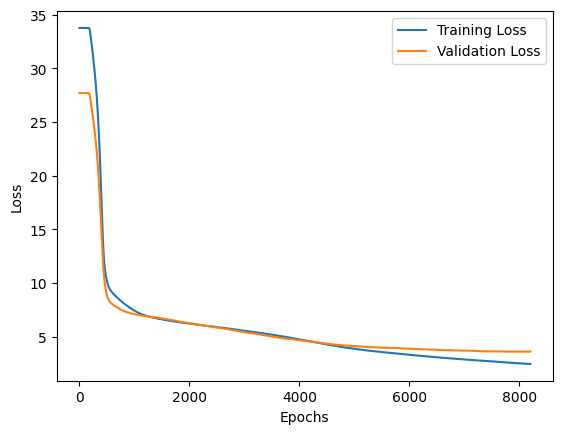

In [36]:
fig, ax = plt.subplots()
plt.plot(range(epochs), train_losses, label="Training Loss")
plt.plot(range(epochs), valid_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("nn_learning_curve.svg")
plt.savefig("nn_learning_curve.png")
plt.show()

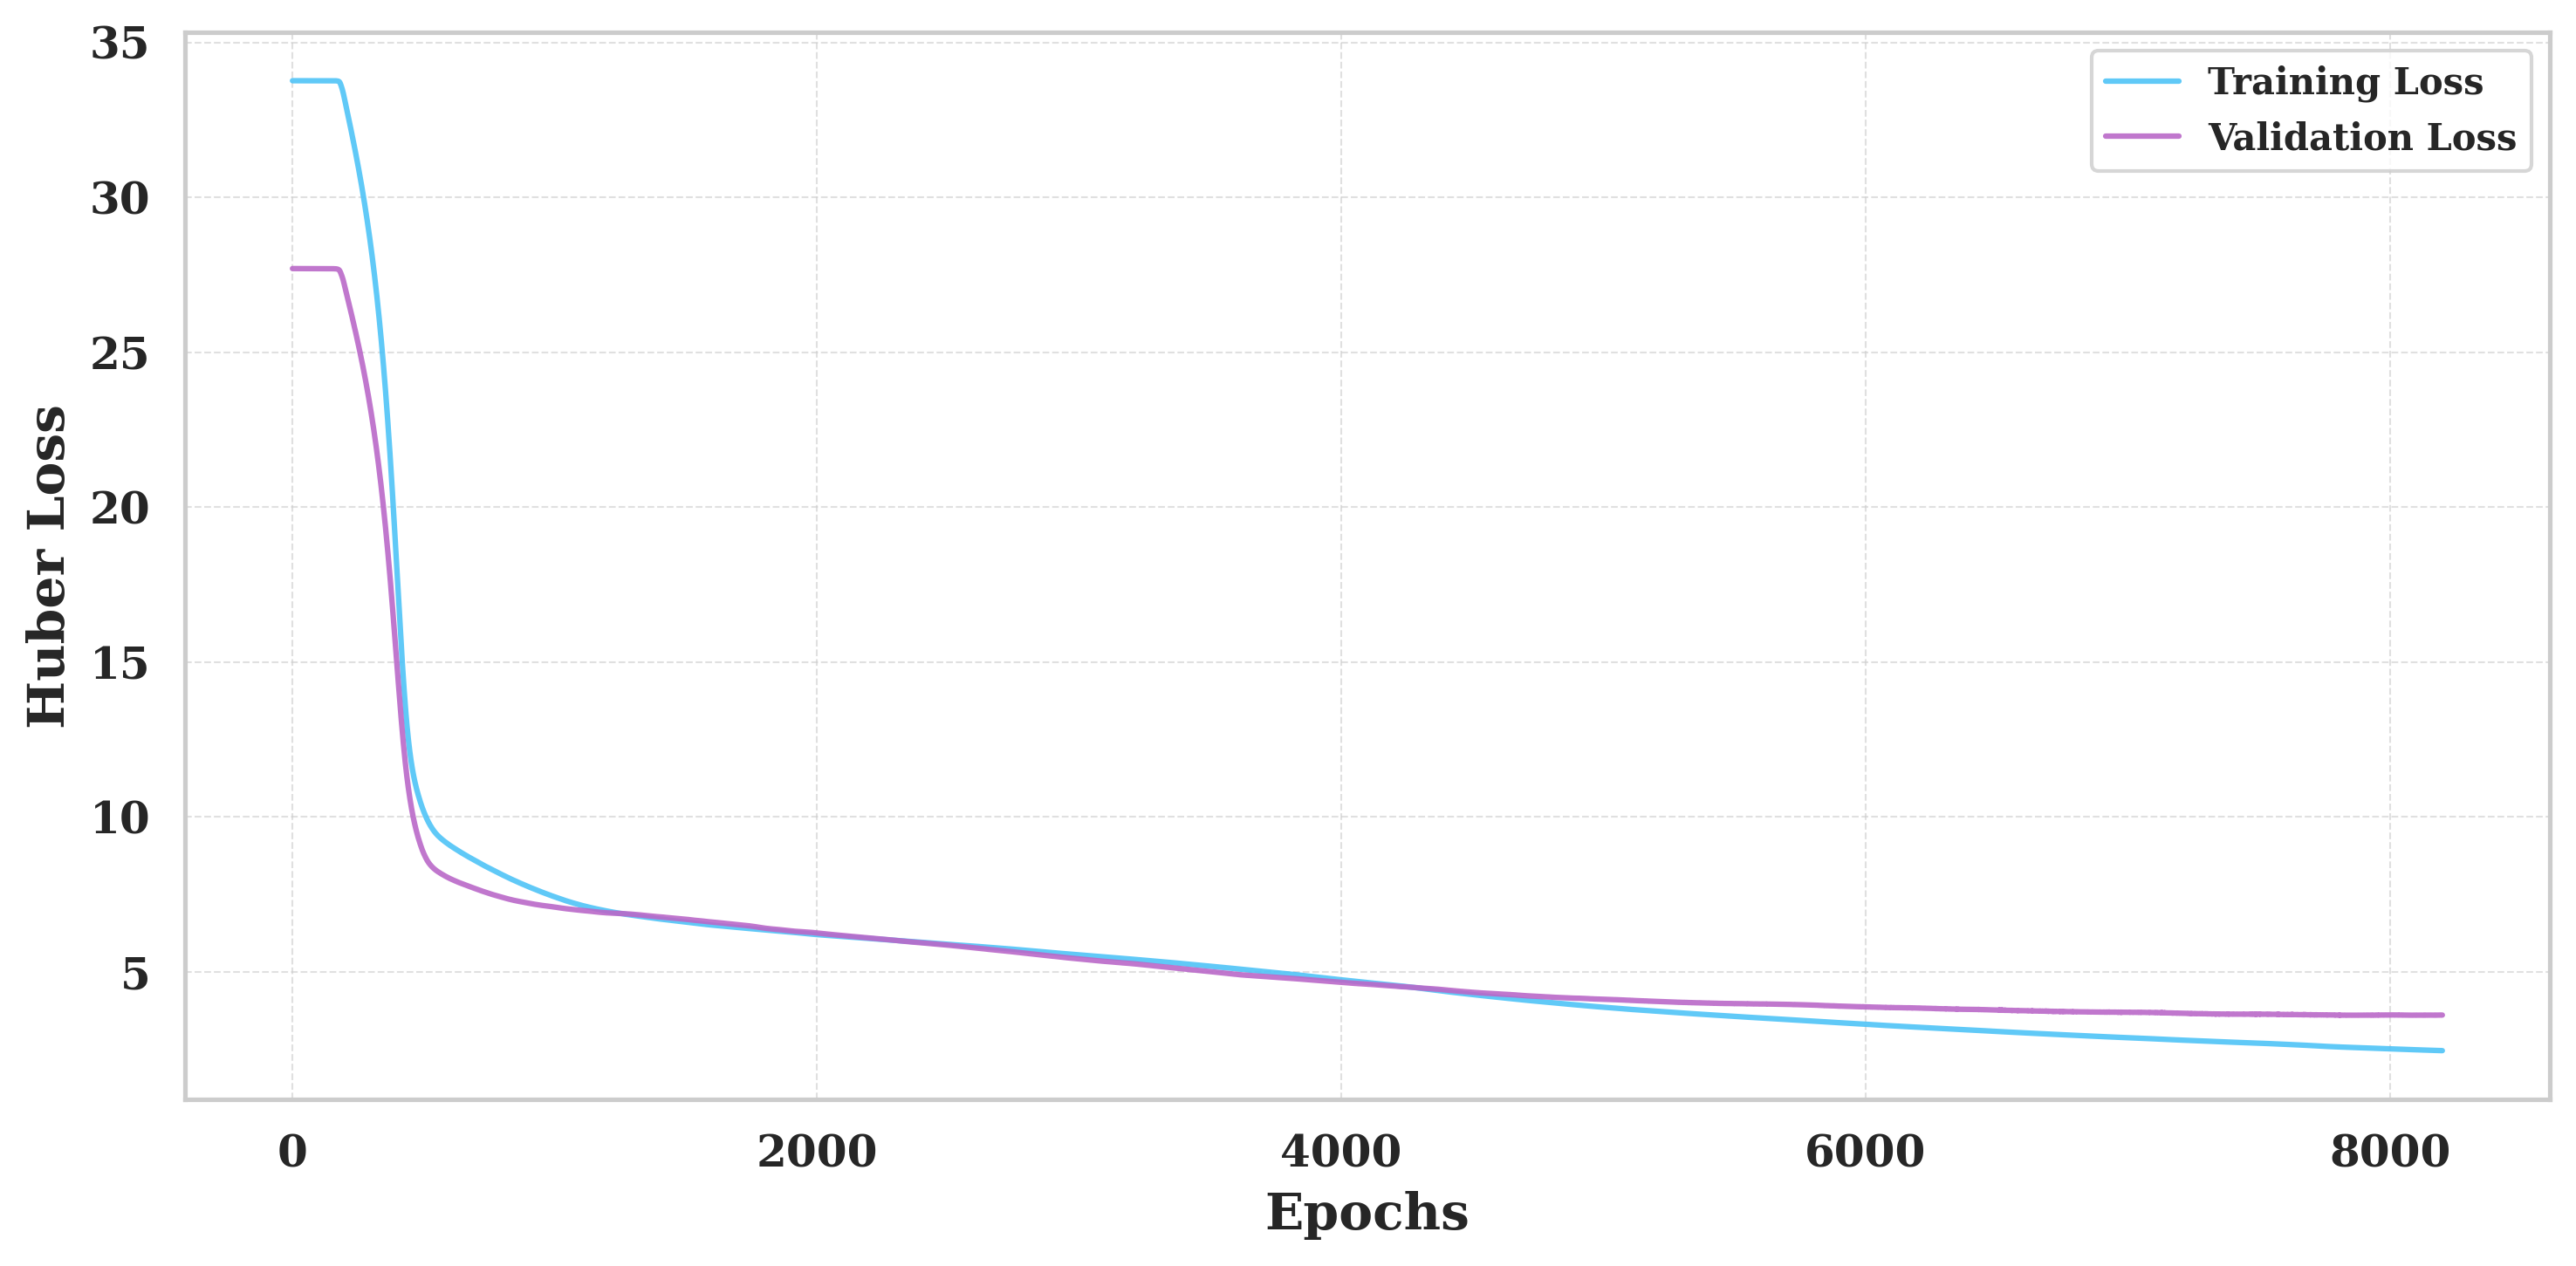

In [37]:
# Use a clean style
sns.set(style="whitegrid")

# Create figure
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

# Plot lines only — no markers
ax.plot(range(epochs), train_losses, label="Training Loss",
        color="#4fc3f7", linewidth=1.5, alpha=0.9)

ax.plot(range(epochs), valid_losses, label="Validation Loss",
        color="#ba68c8", linewidth=1.5, alpha=0.9)

# Labels and title
# ax.set_xlabel("Epochs", fontsize=12)
# ax.set_ylabel("Loss", fontsize=12)
# ax.set_title("Learning Curve alpha_max", fontsize=14, weight="bold")

for text in ax.get_yticklabels():
    text.set_fontsize(12)  # Increase font size
    text.set_fontweight('bold')  # Make text bold
    text.set_fontfamily('serif')

for text in ax.get_xticklabels():
    text.set_fontsize(12)  # Increase font size
    text.set_fontweight('bold')  # Make text bold
    text.set_fontfamily('serif')

# Labels and Title
ax.set_xlabel("Epochs", fontsize=14, fontweight='bold', fontfamily='serif')
ax.set_ylabel("Huber Loss", fontsize=14, fontweight='bold', fontfamily='serif')

# Grid and legend
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
legend = ax.legend(fontsize=10)

for text in legend.get_texts():
    text.set_fontfamily('serif')     # or 'Times New Roman', etc.
    text.set_fontweight('bold')
    text.set_fontstyle('normal')     # optional: italic, normal, oblique

# Tight layout and save
plt.tight_layout()
plt.savefig("nn_learning_curve_alphamax.svg", bbox_inches="tight")
plt.savefig("nn_learning_curve_alphamax.png", dpi=600, bbox_inches="tight")
plt.show()

In [38]:
model.eval()
with torch.inference_mode():
    y_train_pred = model(X_train).squeeze()
    y_val_pred = model(X_val).squeeze()
    y_external_pred = model(X_external).squeeze()
    # y_pred = model(X_test).squeeze()

In [39]:
# y_pred = y_pred.numpy()
# y_test = y_test.numpy()

y_val_pred = y_val_pred.numpy()
y_val = y_val.numpy()

y_train = y_train.numpy()
y_train_pred = y_train_pred.numpy()

y_external = y_external.numpy()
y_external_pred = y_external_pred.numpy()

In [40]:
print("\nTraining Metrics:\n")
print("R2 Score: ", round(r2_score(y_train, y_train_pred), 2))
print("Mean Absolute Error: ", round(mean_absolute_error(y_train, y_train_pred), 2))
print("Mean Absolute Percentage Error: ", round(mean_absolute_percentage_error(y_train, y_train_pred), 2))
print("Root Mean Squared Error: ", round(root_mean_squared_error(y_train, y_train_pred), 2))
print("-"*50)
print("\nValidation Metrics:\n")
print("R2 Score: ", round(r2_score(y_val, y_val_pred), 2))
print("Mean Absolute Error: ", round(mean_absolute_error(y_val, y_val_pred), 2))
print("Mean Absolute Percentage Error: ", round(mean_absolute_percentage_error(y_val, y_val_pred), 2))
print("Root Mean Squared Error: ", round(root_mean_squared_error(y_val, y_val_pred), 2))
print("-"*50)


Training Metrics:

R2 Score:  0.83
Mean Absolute Error:  1.63
Mean Absolute Percentage Error:  0.59
Root Mean Squared Error:  2.22
--------------------------------------------------

Validation Metrics:

R2 Score:  0.81
Mean Absolute Error:  2.08
Mean Absolute Percentage Error:  1.46
Root Mean Squared Error:  2.69
--------------------------------------------------


In [41]:
y_external_pred

array([ 6.8979974,  2.1797476,  6.905792 , 12.330299 , 15.102464 ,
        3.292966 , 16.856056 , 19.322369 ], dtype=float32)

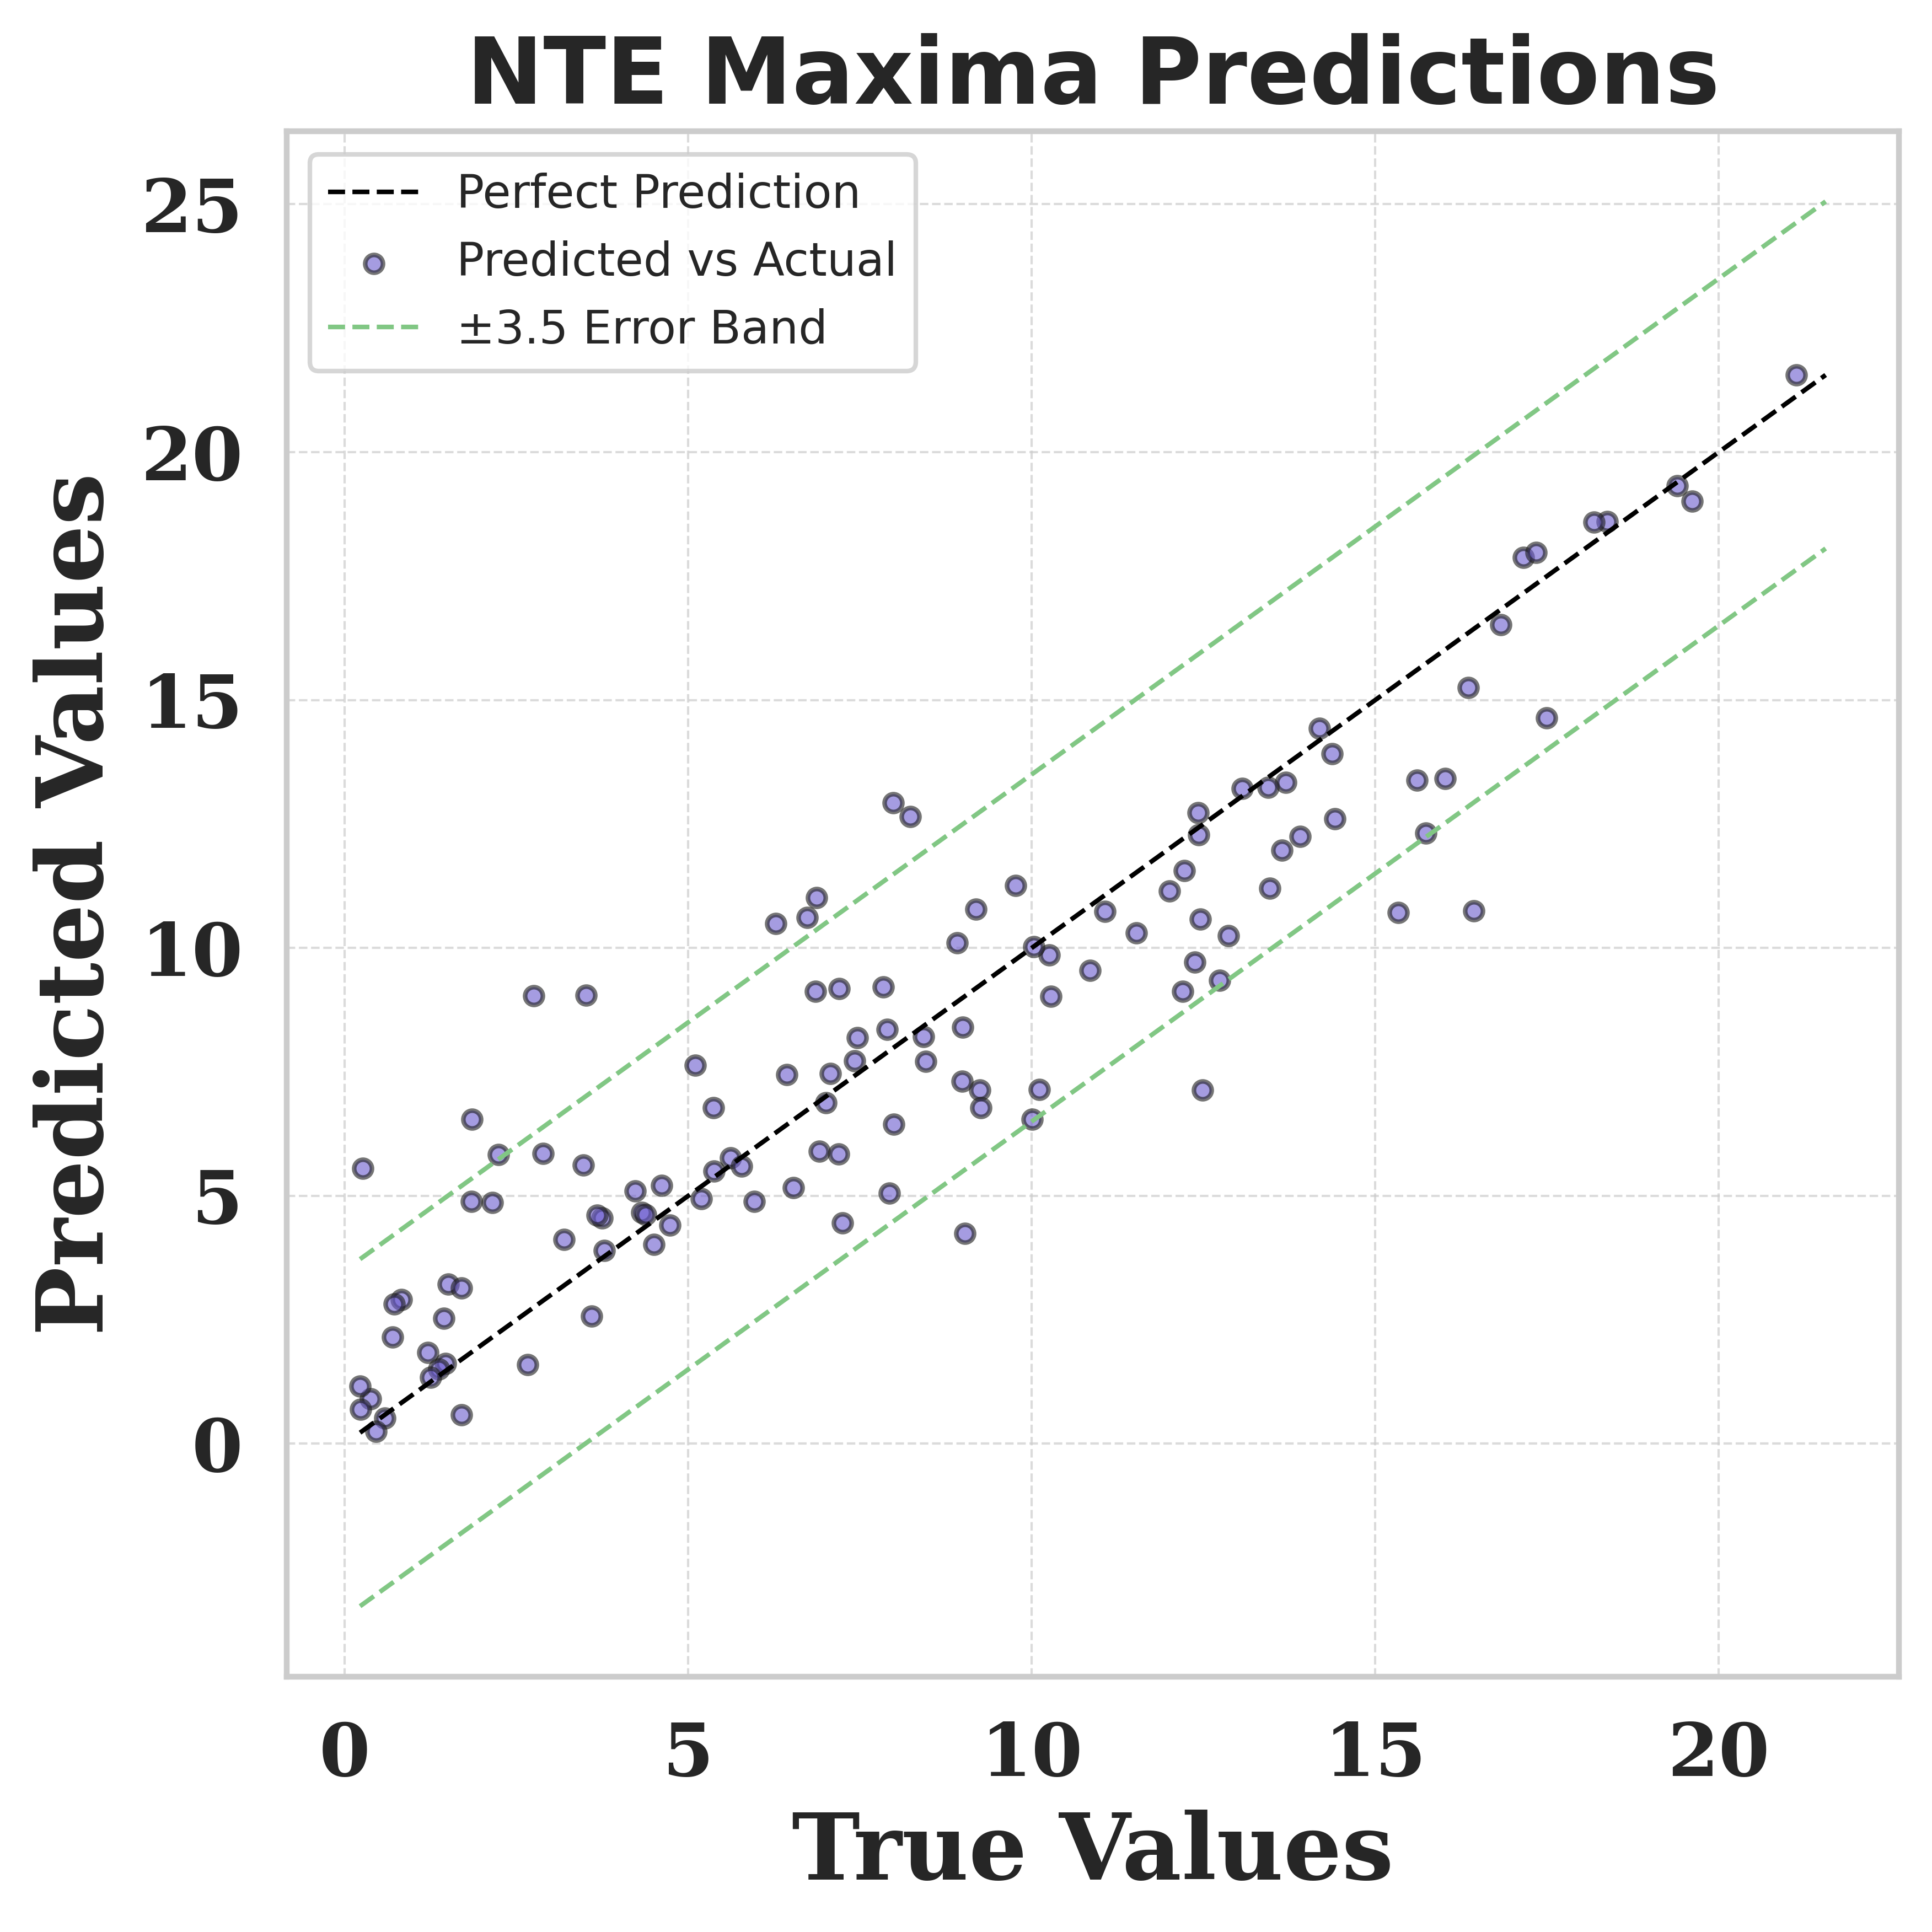

In [42]:
# Optional: use seaborn style for aesthetics
sns.set(style="whitegrid")

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 6), dpi=600)

# Compute min and max for diagonal and offset lines
min_y = min( min(y_train), min(y_train_pred))
max_y = max( max(y_train), max(y_train_pred))

# Plotting
ax.plot([min_y, max_y], [min_y, max_y], label="Perfect Prediction", color="black", linestyle="--", linewidth=1)

# ax.scatter(y_test, y_pred, c="#6a5acd", s=15, alpha=0.6, edgecolor="k", label="Predicted vs Actual")
ax.scatter(y_train, y_train_pred, c="#6a5acd", s=15, alpha=0.6, edgecolor="k", label="Predicted vs Actual")

ax.plot([min_y, max_y], [min_y+3.5, max_y+3.5], linestyle="--", color="#81c784", linewidth=1, label="±3.5 Error Band")
ax.plot([min_y, max_y], [min_y-3.5, max_y-3.5], linestyle="--", color="#81c784", linewidth=1)

for text in ax.get_yticklabels():
    text.set_fontsize(16)  # Increase font size
    text.set_fontweight('bold')  # Make text bold
    text.set_fontfamily('serif')

for text in ax.get_xticklabels():
    text.set_fontsize(16)  # Increase font size
    text.set_fontweight('bold')  # Make text bold
    text.set_fontfamily('serif')

# Labels and Title
ax.set_xlabel("True Values", fontsize=12)
ax.set_ylabel("Predicted Values", fontsize=12)
ax.set_title("NTE Maxima Predictions", fontsize=14, weight="bold")

# Modify axis labels and title
ax.set_xlabel(ax.get_xlabel(), fontsize=20, fontweight='bold', fontfamily='serif')
ax.set_ylabel(ax.get_ylabel(), fontsize=20, fontweight='bold', fontfamily='serif')
ax.set_title(ax.get_title(), fontsize=20, fontweight='bold')


# Grid and Legend
ax.legend(loc="upper left", fontsize=10)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Improve layout
plt.tight_layout()

# Save in high-quality formats
# plt.savefig("neural_network_alphamax.svg", bbox_inches='tight')
# plt.savefig("neural_network_alphamax.png", dpi=600, bbox_inches='tight')

plt.show()

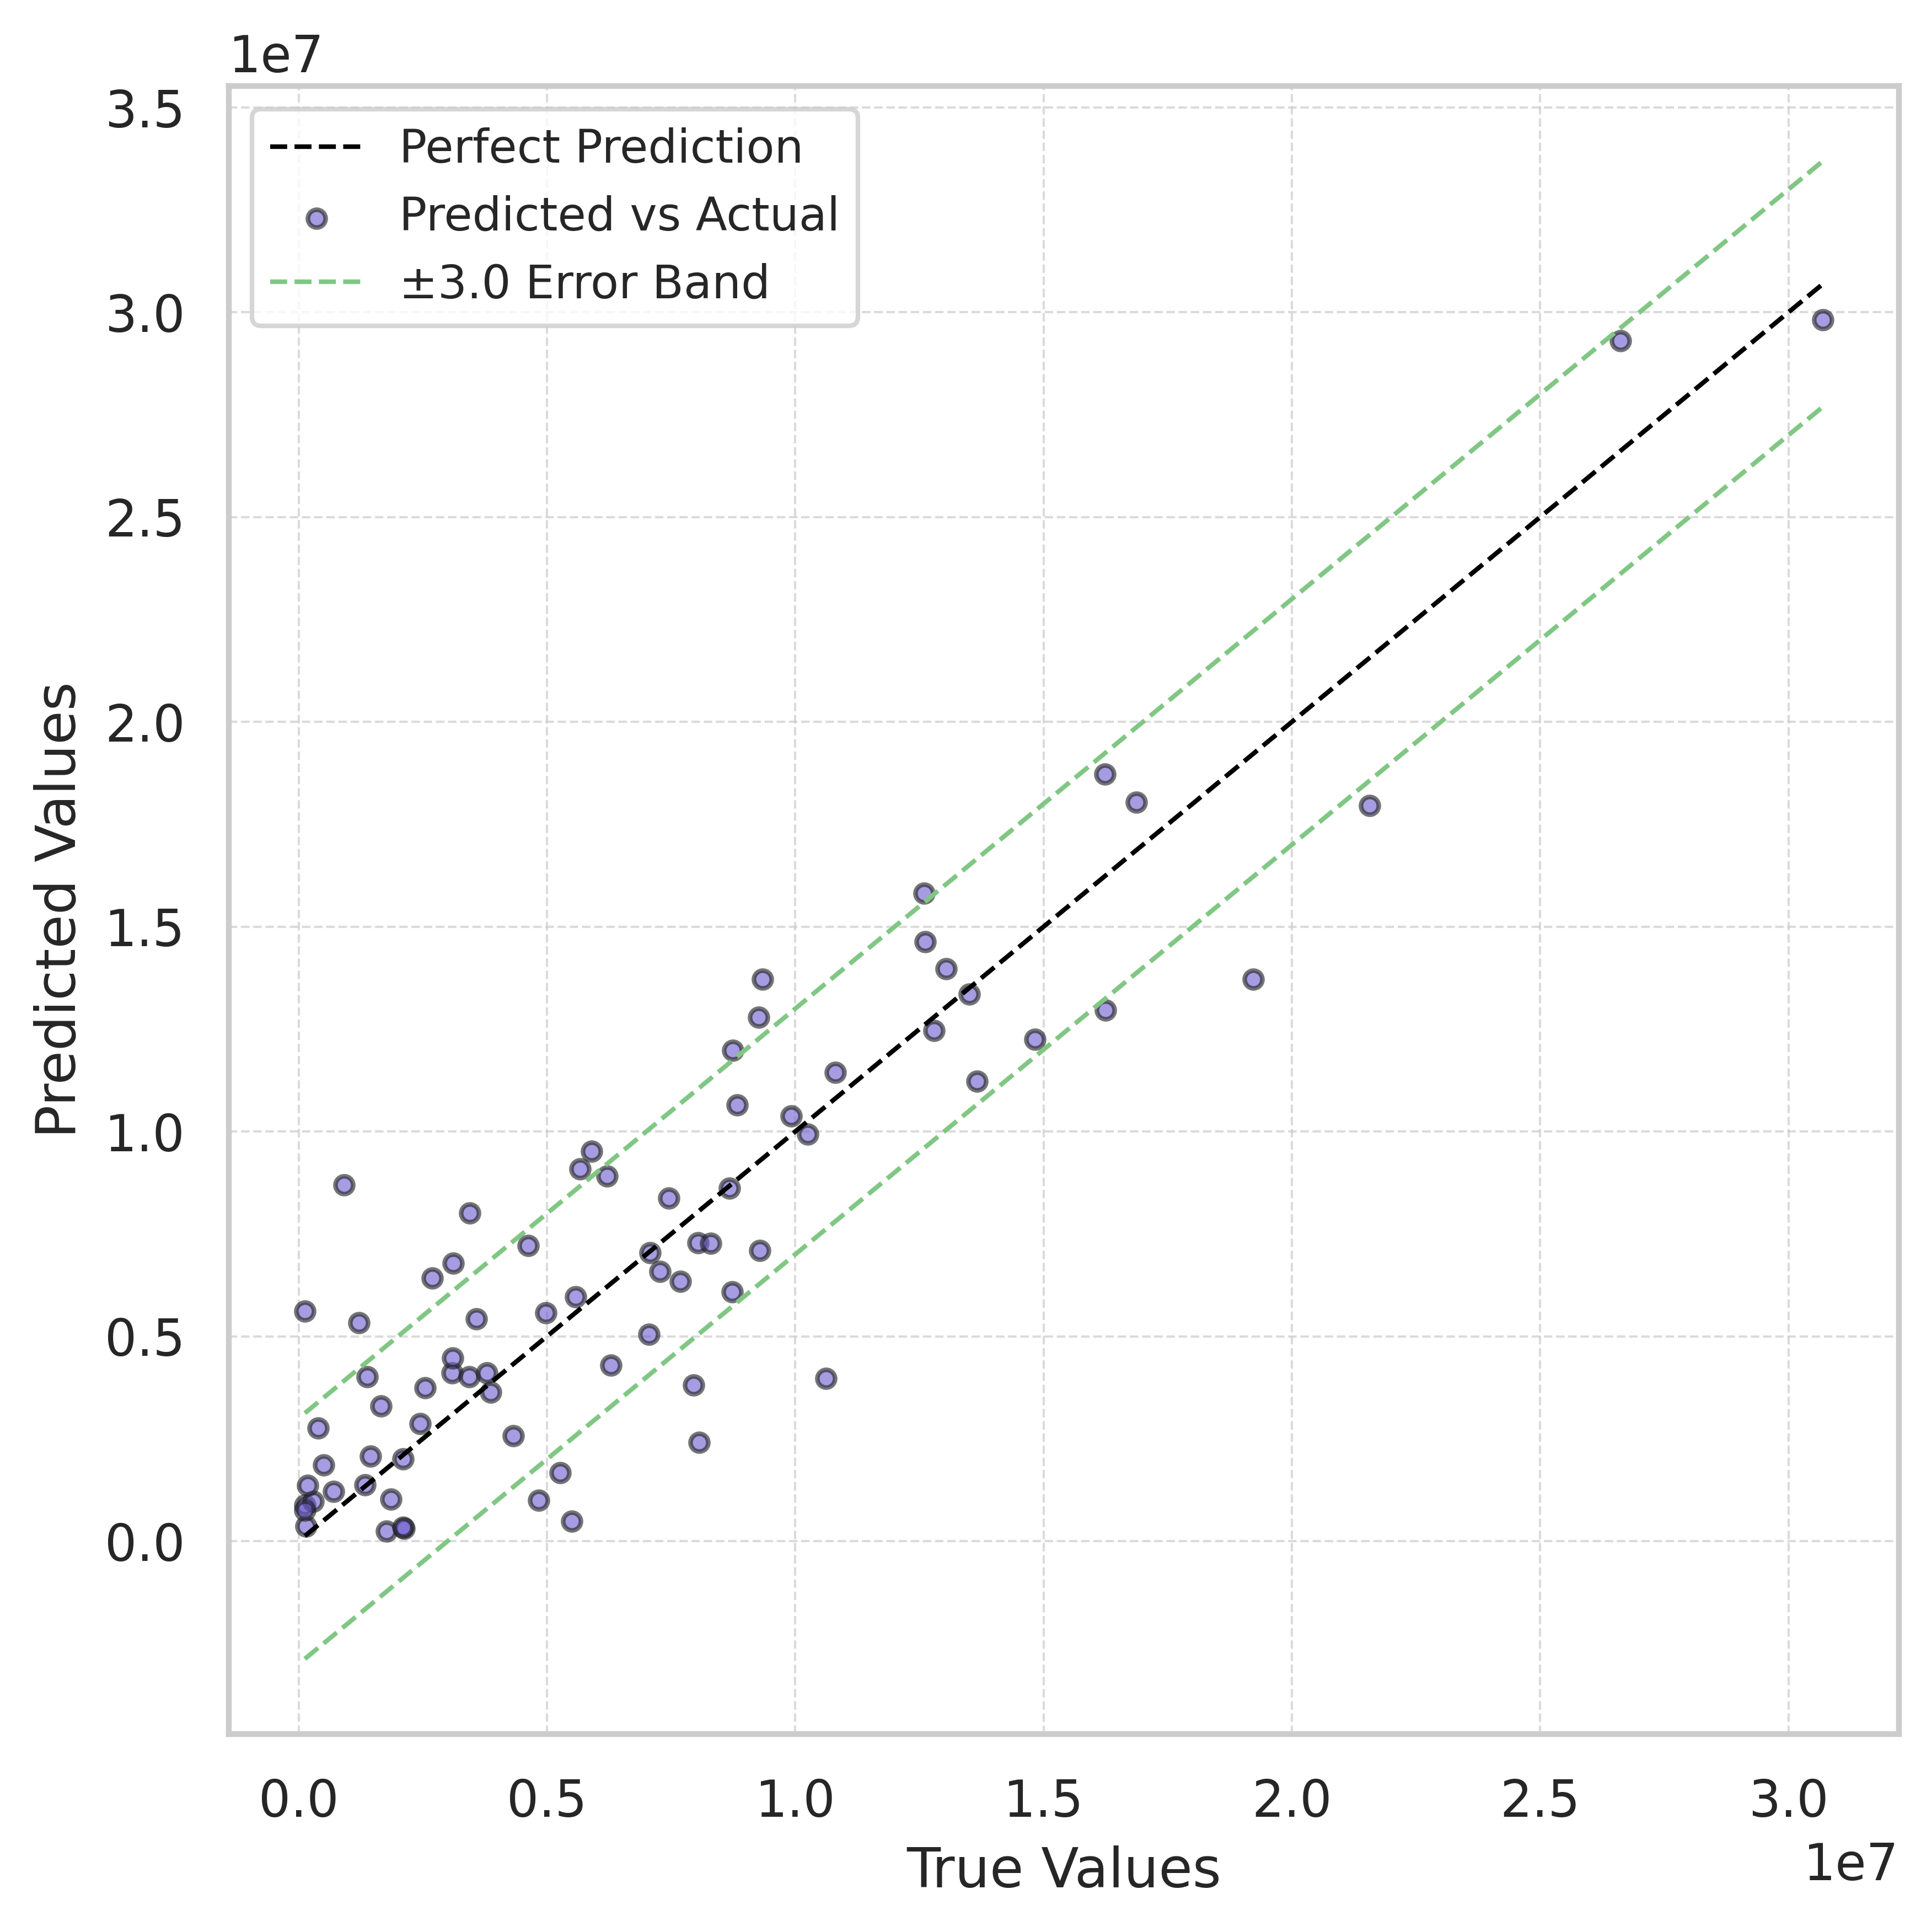

In [43]:
# Optional: use seaborn style for aesthetics
sns.set(style="whitegrid")

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 6), dpi=600)

# Compute min and max for diagonal and offset lines
min_y = min( min(y_val), min(y_val_pred))
max_y = max( max(y_val), max(y_val_pred))

# Plotting
ax.plot(np.array([min_y, max_y])*1e6, np.array([min_y, max_y])*1e6, label="Perfect Prediction", color="black", linestyle="--", linewidth=1)

# ax.scatter(y_test, y_pred, c="#6a5acd", s=15, alpha=0.6, edgecolor="k", label="Predicted vs Actual")
ax.scatter(np.array(y_val)*1e6, np.array(y_val_pred)*1e6, c="#6a5acd", s=15, alpha=0.6, edgecolor="k", label="Predicted vs Actual")

ax.plot(np.array([min_y, max_y])*1e6, np.array([min_y+3.0, max_y+3.0])*1e6, linestyle="--", color="#81c784", linewidth=1, label="±3.0 Error Band")
ax.plot(np.array([min_y, max_y])*1e6, np.array([min_y-3.0, max_y-3.0])*1e6, linestyle="--", color="#81c784", linewidth=1)

# Labels and Title
ax.set_xlabel("True Values", fontsize=12)
ax.set_ylabel("Predicted Values", fontsize=12)

# Grid and Legend
ax.legend(loc="upper left", fontsize=10)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Improve layout
plt.tight_layout()

# # Save in high-quality formats
# plt.savefig("neural_network_alphamax.svg", bbox_inches='tight')
# plt.savefig("neural_network_alphamax.png", dpi=600, bbox_inches='tight')

plt.show()

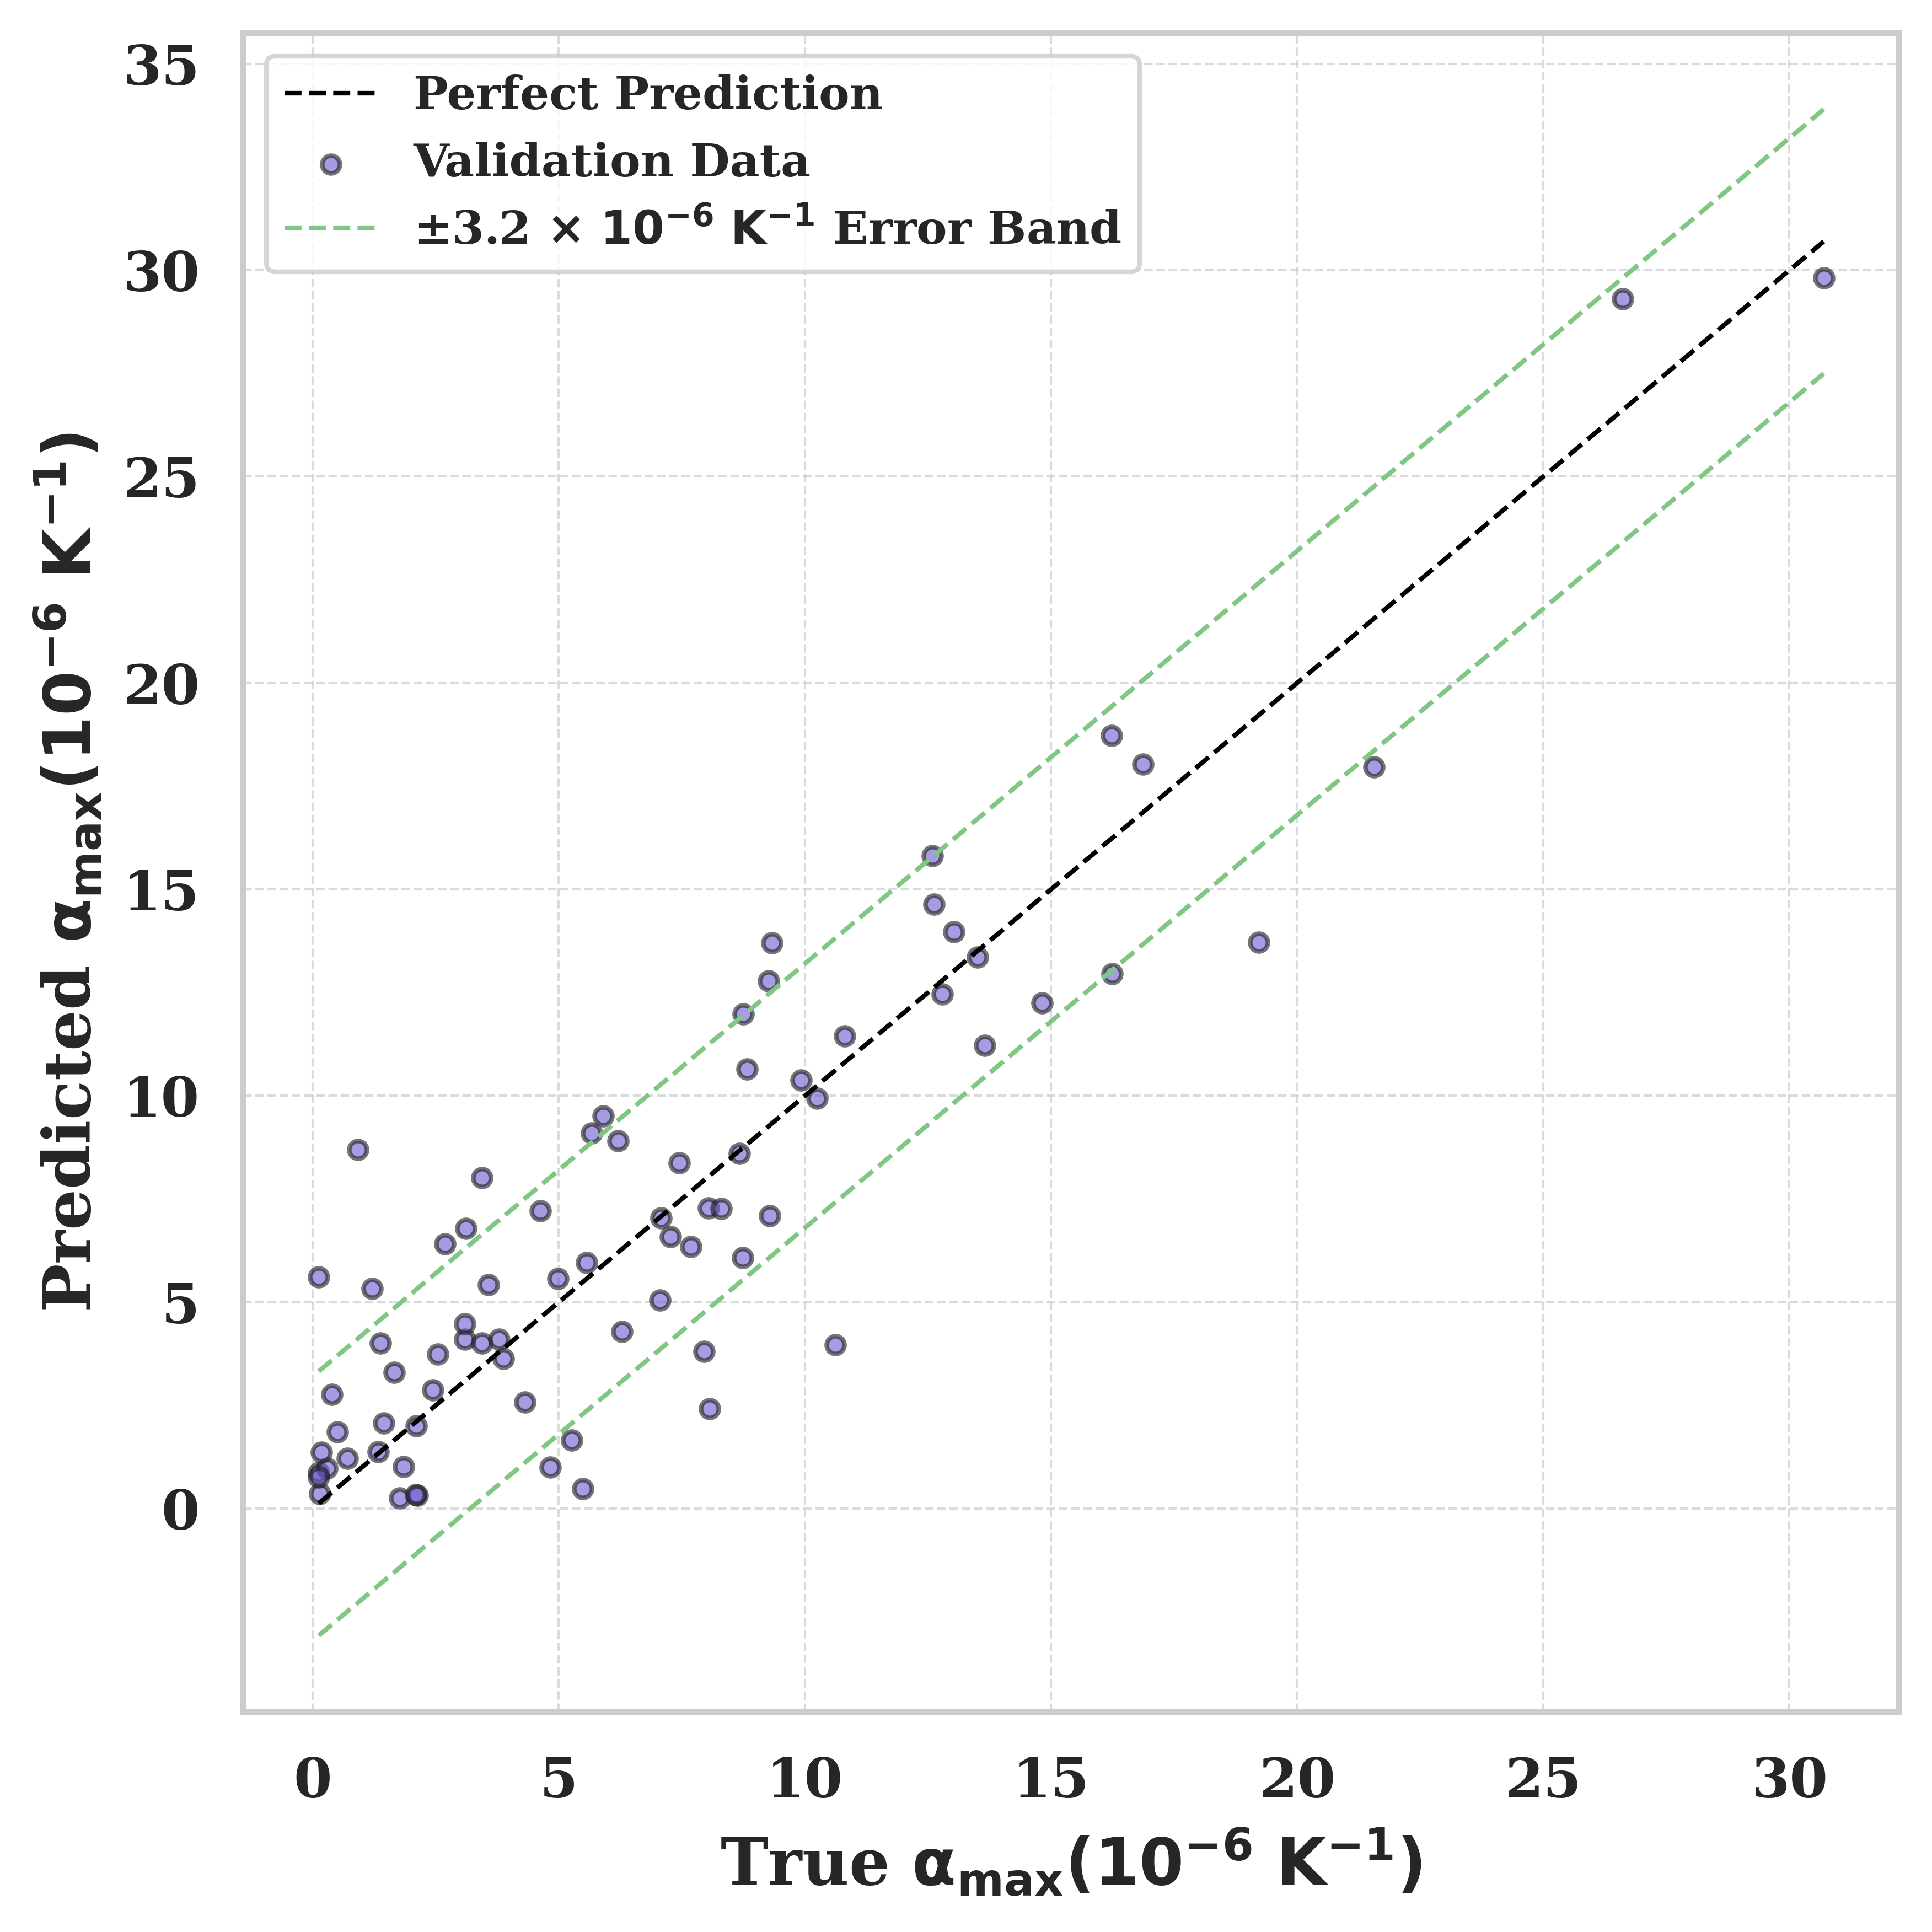

In [44]:
# Optional: use seaborn style for aesthetics
sns.set(style="whitegrid")

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 6), dpi=600)

# Compute min and max for diagonal and offset lines
min_y = min( min(y_val), min(y_val_pred))
max_y = max( max(y_val), max(y_val_pred))

# Plotting
ax.plot(np.array([min_y, max_y]), np.array([min_y, max_y]), label="Perfect Prediction", color="black", linestyle="--", linewidth=1)

# ax.scatter(y_test, y_pred, c="#6a5acd", s=15, alpha=0.6, edgecolor="k", label="Predicted vs Actual")
# ax.scatter(y_train, y_train_pred, c="#6a5acd", s=15, alpha=0.6, edgecolor="k", marker='d', label="Training Data")
ax.scatter(y_val, y_val_pred, c="#6a5acd", s=15, alpha=0.6, edgecolor="k", label="Validation Data")

ax.plot(np.array([min_y, max_y]), np.array([min_y+3.2, max_y+3.2]), linestyle="--", color="#81c784", 
        linewidth=1, label= r"±3.2 " + r"$\mathbf{\times\ 10^{-6}\ K^{-1}}$" + r" Error Band")
ax.plot(np.array([min_y, max_y]), np.array([min_y-3.2, max_y-3.2]), linestyle="--", color="#81c784", linewidth=1)

# Labels and Title
# ax.set_xlabel("True Values ", fontsize=12)
# ax.set_ylabel("Predicted Values ($10^{-6}$ $K^{-1}$)", fontsize=12)

for text in ax.get_yticklabels():
    text.set_fontsize(12)  # Increase font size
    text.set_fontweight('bold')  # Make text bold
    text.set_fontfamily('serif')

for text in ax.get_xticklabels():
    text.set_fontsize(12)  # Increase font size
    text.set_fontweight('bold')  # Make text bold
    text.set_fontfamily('serif')

# Modify axis labels and title
ax.set_xlabel(
    r"True " + r"$\mathbf{\alpha_{max}}$" + r"$\mathbf{(10^{-6}\ K^{-1})}$",
    fontsize=14,
    fontweight='bold',
    fontfamily="serif"
)
ax.set_ylabel(
    r"Predicted " + r"$\mathbf{\alpha_{max}}$" + r"$\mathbf{(10^{-6}\ K^{-1})}$",
    fontsize=14,
    fontweight="bold",
    fontfamily="serif"
)
#

# Grid and Legend
legend = ax.legend(loc="upper left", fontsize=10)

for text in legend.get_texts():
    text.set_fontfamily('serif')     # or 'Times New Roman', etc.
    text.set_fontweight('bold')
    text.set_fontstyle('normal')     # optional: italic, normal, oblique
    
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Improve layout
plt.tight_layout()

# Save in high-quality formats
plt.savefig("neural_network_alphamax.svg", bbox_inches='tight')
plt.savefig("neural_network_alphamax.png", dpi=600, bbox_inches='tight')

plt.show()

In [45]:
from scipy.stats import ttest_rel

# Assume y_test are true values, y_pred are model predictions
y_mean_pred = np.mean(y_val)  # Null model prediction (mean of y_test)

# Compute absolute errors
errors_model = np.abs(y_val - y_val_pred)
errors_null = np.abs(y_val - y_mean_pred)

print(np.mean(errors_model), np.mean(errors_null))

# Perform paired t-test
t_stat, p_value = ttest_rel(errors_null, errors_model)

print(f"T-statistic: {t_stat}, p-value: {p_value}")

2.0826464 4.667492
T-statistic: 5.212170822942475, p-value: 1.5917972494898142e-06


In [46]:
labels = []
values = []
for label, value in list(zip(train_labels, y_train_pred)):
    labels.append(label)
    values.append(value)

for label, value in list(zip(val_labels, y_val_pred)):
    labels.append(label)
    values.append(value)

nte_max_pred = pd.DataFrame({
    "system":labels,
    "predicted_nte_max":values
})

nte_max_pred.to_csv("nte_max_pred.csv", index=False)

In [47]:
labels = []
true_values = []
pred_values = []
for label, true_value, pred_value in list(zip(train_labels, y_train, y_train_pred)):
    labels.append(label)
    true_values.append(true_value)
    pred_values.append(pred_value)

for label, true_value, pred_value in list(zip(val_labels, y_val, y_val_pred)):
    labels.append(label)
    true_values.append(true_value)
    pred_values.append(pred_value)

nte_max_model = pd.DataFrame({
    "system":labels,
    "true_vales":true_values,
    "pred_values":pred_values,
    "error": np.array(pred_values) - np.array(true_values)
})

nte_max_model.to_csv("nte_max_model.csv", index=False)

In [48]:
len(nte_max_pred)

192

In [49]:
feature_names

Index(['density', 'mean_coordination', 'reduced_mass', 'bond_types',
       'effective_electronegativity', 'types_of_bond_angle', 'symmetry_number',
       'angle_variance', 'bond_density', 'z_variance', 'spin_orbit_coupling',
       'entropy'],
      dtype='object')

In [50]:
feature_names = [r'$\boldsymbol{\rho}$', r'$\overline{\mathbf{C.N}}$', r'$\bar{\boldsymbol{\mu}}$', 
                 'B_typ', r'$\bar{\boldsymbol{\chi}}$', 'BA_typ', 'symm', 'a_var', 'BD', 'z_var', 
                 r"$\mathbf{Q^{4}}$", 'CE']

In [51]:
import shap

# Define a simple prediction function using your PyTorch model
def model_predict(x_numpy):
    x_tensor = torch.from_numpy(x_numpy.astype(np.float32))
    with torch.no_grad():
        preds = model(x_tensor).numpy().flatten()
    return preds

# Use KernelExplainer with a background sample (e.g., 100 random points)
X_train_df = pd.DataFrame(X_train.numpy(), columns=feature_names)
background = shap.sample(X_train_df, len(X_train_df))

X_test_df = pd.DataFrame(X_val.numpy(), columns=feature_names)
# X_test_df = pd.DataFrame(X_test.numpy(), columns=feature_names)

# X_test_df = pd.DataFrame(X_val_df, ignore_index=True)

explainer = shap.KernelExplainer(model_predict, background)
shap_values = explainer.shap_values(X_test_df)

Using 116 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/76 [00:00<?, ?it/s]

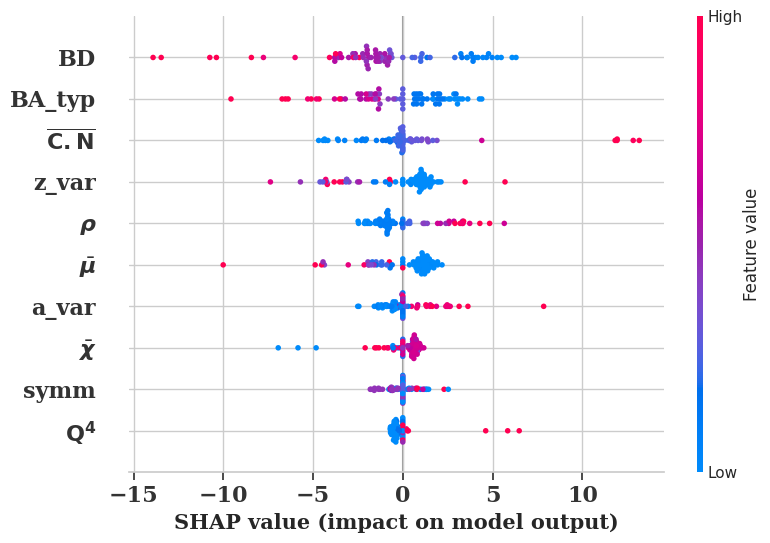

In [52]:
fig = shap.summary_plot(shap_values, X_test_df, max_display=10, show=False)

ax = plt.gca()

# Modify feature names (y-axis labels)
for text in ax.get_yticklabels():
    text.set_fontsize(16)  # Increase font size
    text.set_fontweight('bold')  # Make text bold
    text.set_fontfamily('serif')

for text in ax.get_xticklabels():
    text.set_fontsize(16)  # Increase font size
    text.set_fontweight('bold')  # Make text bold
    text.set_fontfamily('serif')

# Modify axis labels and title
ax.set_xlabel(ax.get_xlabel(), fontsize=15, fontweight='bold', fontfamily='serif')
# ax.set_ylabel(ax.get_ylabel(), fontsize=20, fontweight='bold')
ax.set_title(ax.get_title(), fontsize=20, fontweight='bold')

plt.savefig("shap_summary_alphamax.png", dpi=600, bbox_inches="tight")  # Save as PNG
plt.savefig("shap_summary_alphamax.svg", dpi=600, bbox_inches="tight")

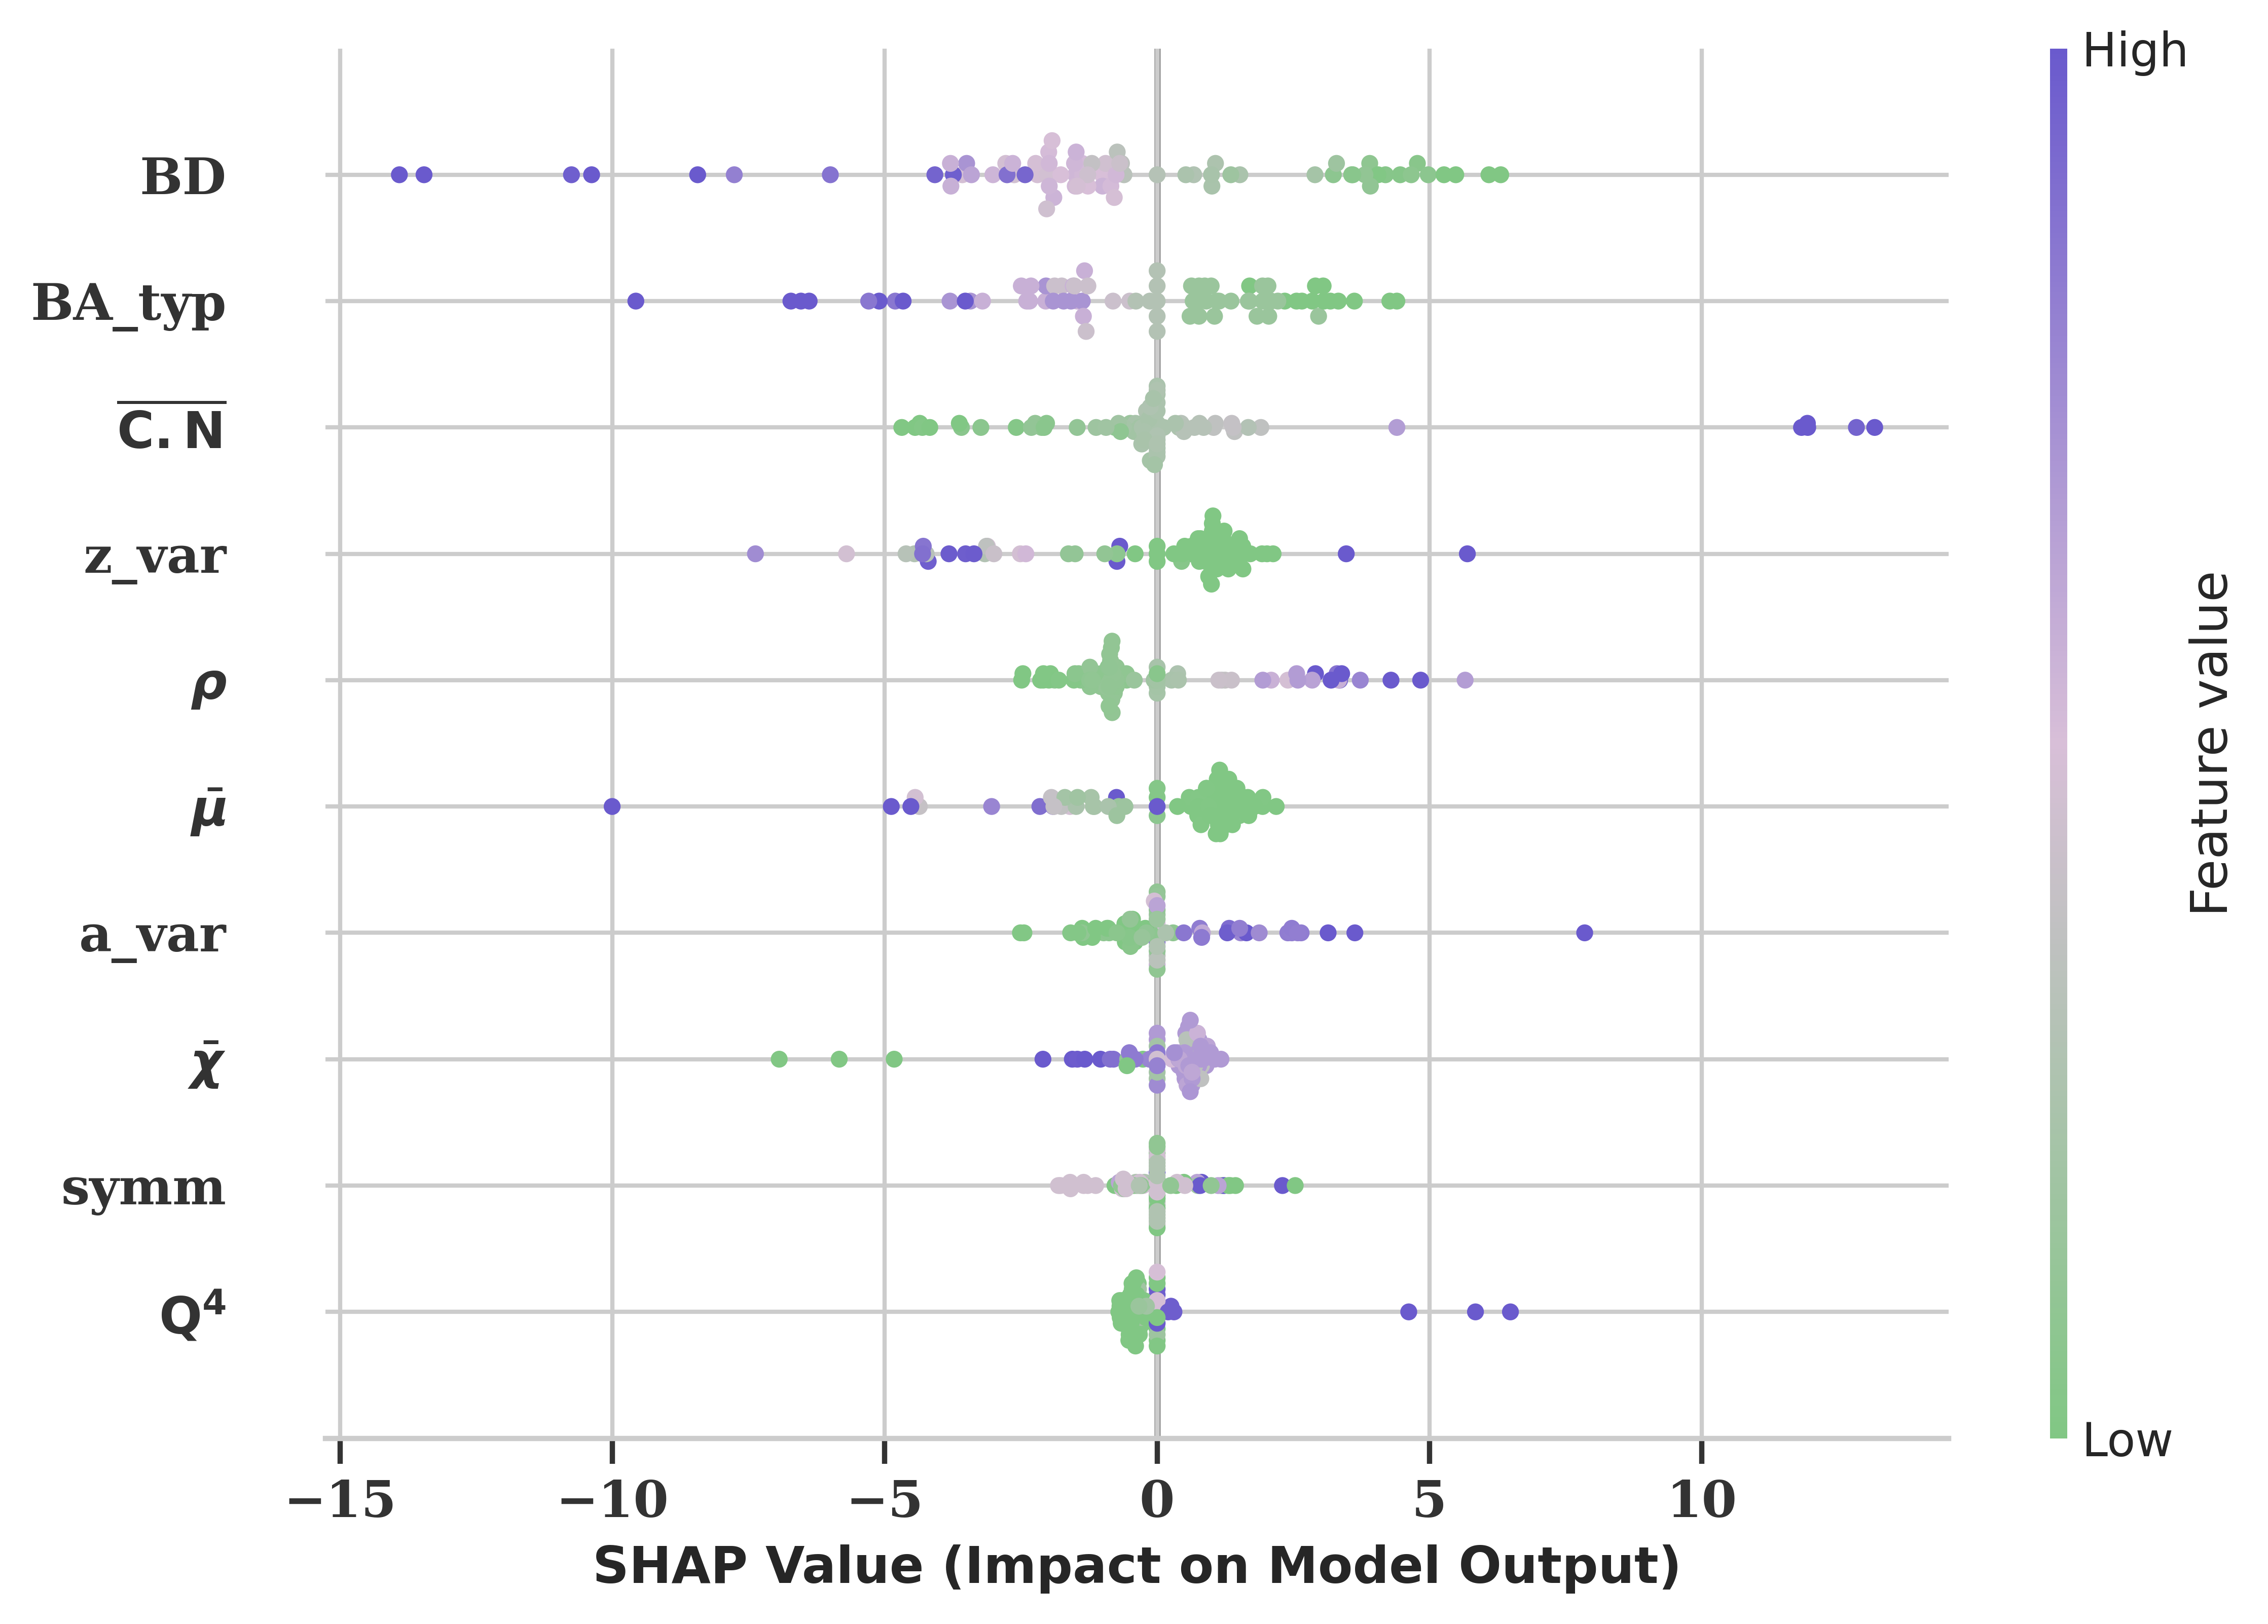

In [53]:
import shap
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define custom cmap
purple_green_cmap = LinearSegmentedColormap.from_list(
    "purple_green",
    [   "#81c784",  # Soft Green
        "#d8bfd8",  # Thistle
     "#6a5acd",  # Slate Blue
    ]
)

# Create SHAP summary plot
fig, ax = plt.subplots(figsize=(8, 6), dpi=600)

shap.summary_plot(
    shap_values,
    X_test_df,
    feature_names=feature_names,
    max_display=10,
    show=False,
    cmap=purple_green_cmap
)

for text in ax.get_yticklabels():
    text.set_fontsize(12)  # Increase font size
    text.set_fontweight('bold')  # Make text bold
    text.set_fontfamily('serif')

for text in ax.get_xticklabels():
    text.set_fontsize(12)  # Increase font size
    text.set_fontweight('bold')  # Make text bold
    text.set_fontfamily('serif')

# plt.title("SHAP Feature Importance", fontsize=14, weight="bold")
plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=12, weight='bold')
plt.tight_layout()
plt.show()

In [54]:
def print_errors(y_true, errors, labels, tol=10.0):
    assert len(errors) == len(labels)
    i = 0
    for error in errors:
        if abs(error) > tol:
            print(f"{labels[i]}: {round(y_true[i], 2):.2f} | {round(error, 2):.2f}")
        i += 1

In [55]:
train_errors = y_train_pred - y_train
val_errors = y_val_pred - y_val

print_errors(y_train, train_errors, train_labels, tol=4.0)
print("-"*20)
# print_errors(test_errors, test_labels, tol=5.0)
# print("-"*20)
print_errors(y_val, val_errors, val_labels, tol=4.0)

AsGY-REC: 12.48 | -5.35
14.14.14-GY: 8.23 | 4.42
AlGY-HEX: 16.43 | -5.68
Si2P2: 2.75 | 6.28
GaGD-HEX: 6.27 | 4.22
GDY-2: 6.87 | 4.15
PHE-graphene: 1.85 | 4.70
biphenylene: 0.26 | 5.29
C9N4: 9.02 | -4.79
GaGY-HEX: 3.51 | 5.53
beta-GY: 7.98 | 4.94
AlGD-HEX: 15.34 | -4.62
--------------------
2: 0.12 | 5.49
BCN-1: 0.92 | 7.77
12: 8.07 | -5.65
8: 1.22 | 4.11
pza_c10: 10.62 | -6.66
beta-β-Sn2N2: 5.50 | -5.02
BC10N2: 3.44 | 4.57
18.18.18-Gy: 19.22 | -5.50
beta-β-Sn2As2: 9.34 | 4.38
AsGD-REC: 7.95 | -4.14
